In [1]:
## It seems like scale of noisy and clean spectra change because of normalisation or something.
# The GAN copes with this well, as it adpats noisy spectra to match this property of clean spectra.
# But classicasl denoising techniques don't take this into account. 

# This means that when we denoise using classical techniques, we need to somehow account for the 
#normalisation to make the comparison meaningful. 

# Seems like the may have normalised by a peak or something. Not a bad idea.
# i.e. make specrra 1 at same wavenumber where peak occurs
# https://www.impopen.com/subs/jsi/v11/I11_a7.pdf
# https://pubs.acs.org/doi/10.1021/acs.analchem.1c02178

#baseline correct spectra
# normalise by max value
# Then compute MSE

In [2]:
#savistky golay filtering is the most common spectral denoising method.
# we will compare our cycleGAN's denoised spectra to those smoothed with savistky golay filtering
# https://www.datatechnotes.com/2022/05/smoothing-example-with-savitzky-golay.html

import numpy as np
from scipy import signal
import matplotlib.pyplot as plt

from BaselineRemoval import BaselineRemoval

network_pred = np.load('network_denoised.npy')
network_pred_GT = np.load('network_denoised_GT.npy')
network_pred_input = np.load('network_input.npy')

noisy_tr = np.load('hn_train_set.npy')


#noisy_va = np.load('hn_valid_set.npy')
#clean_va = np.load('ln_valid_set.npy')

In [3]:


network_pred=np.load('network_denoised.npy')
network_pred_GT = np.load('network_denoised_GT.npy')
network_pred_input = np.load('network_input.npy')
network_pred_input_baseline_norm = network_pred_input

In [4]:

print(network_pred[100])

[0.08606787 0.08657275 0.08505446 0.08701739 0.08601587 0.08541487
 0.08433729 0.08394413 0.08463825 0.08271326 0.08236823 0.08033182
 0.07948244 0.08106469 0.08256651 0.08130214 0.07766875 0.07858977
 0.08057898 0.08113698 0.07848106 0.07635849 0.07514818 0.07522996
 0.07359456 0.07788272 0.07847181 0.07751996 0.07355497 0.07772969
 0.07958291 0.08007507 0.07864516 0.0760425  0.07385487 0.07337888
 0.07375322 0.07074754 0.06976421 0.07567748 0.0725885  0.07407609
 0.07242389 0.07237747 0.06750043 0.07067531 0.07044923 0.07222181
 0.06741371 0.07473648 0.07023602 0.0689243  0.07269488 0.06463397
 0.06080049 0.06530239 0.06607385 0.06651273 0.06736144 0.06764766
 0.06243855 0.06562323 0.06823302 0.06894027 0.06765132 0.06913347
 0.06400509 0.06334284 0.06270634 0.06384392 0.06121355 0.05950123
 0.06391572 0.06298843 0.06632413 0.06134669 0.06233591 0.06264465
 0.06228184 0.05686102 0.06370759 0.05757591 0.05760367 0.06134659
 0.05650236 0.05544155 0.05547532 0.05870248 0.05605859 0.0561

In [5]:
#baseline correct and normalise based on max value

for i in range(np.shape(network_pred)[0]):
    baseObj=BaselineRemoval(network_pred_GT[i])
    Modpoly_output=baseObj.ModPoly(3)
    network_pred_GT[i] = Modpoly_output/np.max(Modpoly_output)
    
    baseObj=BaselineRemoval(network_pred[i])
    Modpoly_output=baseObj.ModPoly(3)
    #network_pred[i] = Modpoly_output/Modpoly_output[np.where(network_pred_GT[i] == np.max(network_pred_GT[i]))[0][0]]
    network_pred[i] = Modpoly_output/np.max(Modpoly_output)
    
    baseObj=BaselineRemoval(network_pred_input[i])
    Modpoly_output=baseObj.ModPoly(3)
    #network_pred[i] = Modpoly_output/Modpoly_output[np.where(network_pred_GT[i] == np.max(network_pred_GT[i]))[0][0]]
    network_pred_input_baseline_norm[i] = Modpoly_output/np.max(Modpoly_output)
    
    
    



In [6]:
network_MSE = np.mean(np.mean((np.squeeze(network_pred) - np.squeeze(network_pred_GT))**2,axis=1))

In [7]:
np.shape(network_pred)

(12600, 500)

0.022144250704377484


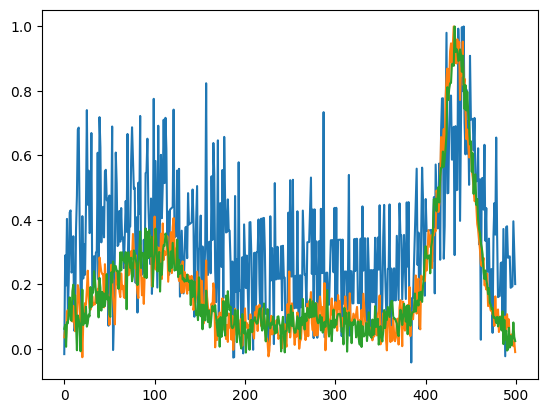

In [8]:
index = 50
print(network_MSE)
plt.plot(network_pred_input_baseline_norm[index])
plt.plot(network_pred[index])
plt.plot(network_pred_GT[index])

In [9]:
test_example = np.squeeze(network_pred_input)



    

y_smooth = signal.savgol_filter(test_example, window_length=50, polyorder=3, mode="nearest")


for i in range(np.shape(y_smooth)[0]):
    baseObj=BaselineRemoval(y_smooth[i])
    mod=baseObj.ModPoly(3)
    y_smooth[i]=mod/np.max(mod)

In [10]:
np.shape(y_smooth)

(12600, 500)

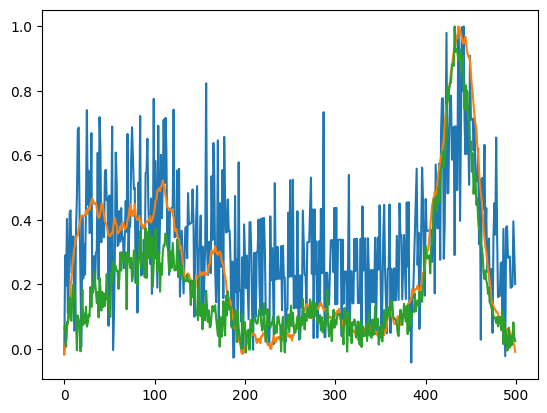

In [11]:
#for i in range(np.shape(y_smooth)[0]):
 #   y_smooth[i] = y_smooth[i]/np.max(y_smooth[i])
    

plt.plot(network_pred_input_baseline_norm[index])
plt.plot(y_smooth[index])
plt.plot(network_pred_GT[index])



In [12]:
SG_MSE = np.mean(np.mean((np.squeeze(y_smooth) - np.squeeze(network_pred_GT))**2,axis=1))
print(SG_MSE)

0.03591827320750099


In [27]:
#PCA denoising - https://scikit-learn.org/stable/auto_examples/applications/plot_digits_denoising.html

from sklearn.decomposition import PCA, KernelPCA

pca = PCA(n_components=50)
#kernel_pca = KernelPCA(
#    n_components=15, kernel="rbf", gamma=1e-3, fit_inverse_transform=True, alpha=5e-3
#)

pca.fit(np.squeeze(np.squeeze(noisy_tr)))
#_ = kernel_pca.fit(np.squeeze(noisy_tr))

#X_reconstructed_kernel_pca = kernel_pca.inverse_transform(
#    kernel_pca.transform(test_example)
#)


PCA(n_components=50)

In [28]:
X_reconstructed_pca = pca.inverse_transform(pca.transform(test_example))

In [29]:

for i in range(np.shape(X_reconstructed_pca)[0]):
    baseObj=BaselineRemoval(X_reconstructed_pca[i])
    mod=baseObj.ModPoly(3)
    X_reconstructed_pca[i]=mod/np.max(mod)


In [30]:
PCA_MSE = np.mean(np.mean((np.squeeze(X_reconstructed_pca) - np.squeeze(network_pred_GT))**2,axis=1))
print(PCA_MSE)

0.15198653705555606


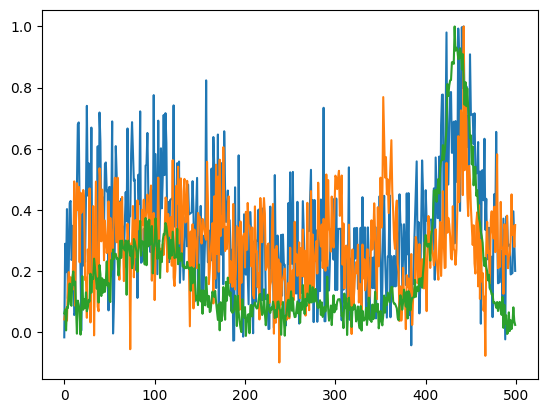

In [31]:
plt.plot(network_pred_input_baseline_norm[index])
plt.plot(np.squeeze(X_reconstructed_pca[index]))
plt.plot(network_pred_GT[index])


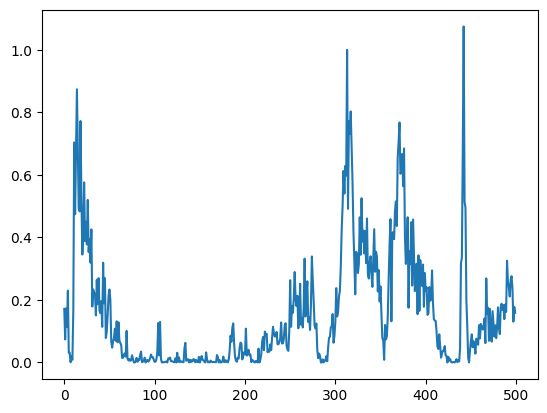

In [18]:
plt.plot((np.squeeze(X_reconstructed_pca[index]) - np.squeeze(network_pred_GT[index]))**2)

In [19]:
# Wavelet denoising

In [20]:
import numpy as np
#import PyWavelets as pywt
from skimage.restoration import denoise_wavelet
import matplotlib.pyplot as plt

x_denoise = denoise_wavelet(test_example, method='BayesShrink', mode='soft', wavelet_levels=10, wavelet='sym8', rescale_sigma='True')

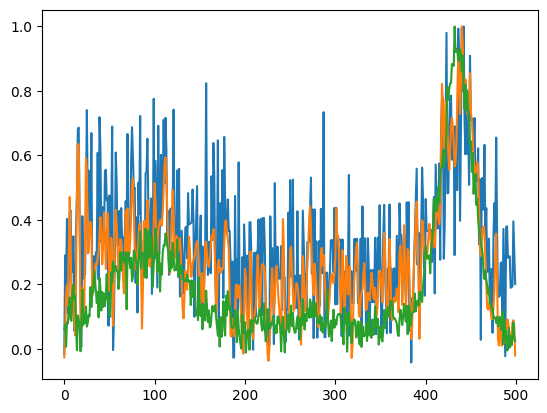

In [21]:


for i in range(np.shape(x_denoise)[0]):
    baseObj=BaselineRemoval(x_denoise[i])
    mod=baseObj.ModPoly(3)
    x_denoise[i]=mod/np.max(mod)


    
plt.plot(network_pred_input_baseline_norm[index])
plt.plot(np.squeeze(x_denoise[index]))
plt.plot(network_pred_GT[index])


In [22]:
wav_MSE = np.mean(np.mean((np.squeeze(x_denoise) - np.squeeze(network_pred_GT))**2,axis=1))
print(wav_MSE)

0.042776353730667536


# NOVA metric - https://www.pythonfordatascience.org/anova-python/#test_with_python

import scipy.stats as stats

stats.f_oneway(np.squeeze(x_denoise), test_example)